# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

Данные взяты с сайта ChaLearn Looking at People.

Оригинальный датасет разбит на тестовый, тренировочный и валидационный.
В нашем распоряжении одна папка со всеми изображениями /datasets/faces/final_files и csv-файл labels.csv с метками, который содержит две колонки:

- file_name - имя файла изображения
- real_age - возраст человека на фотографии.

В оригинальном датасете представлены разнообразные изображения с фотографиями людей во весь рост, портретные фотографии. Для каждого изображения авторы также предоставляют соответствующее изображение, которое содержит только изображения лица, вырезанное из исходного изображения, правильно ориентированное (повернутое) с 40% отступом, полученное с помощью детектора лиц Mathias et. al.

В нашем распоряжении уже обработанный датасет с лицами, таким образом, задачу детекции лиц производить не нужно.

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
from PIL import Image
import numpy as np
import seaborn as sns
import random
sns.set(rc={'figure.figsize':(12,8)})


Загрузим данные

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Уточним больше информации о данных

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Колличество фотографий и значений возроста совпадает

In [4]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Проверим как распределяется реальный возрост на графике

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


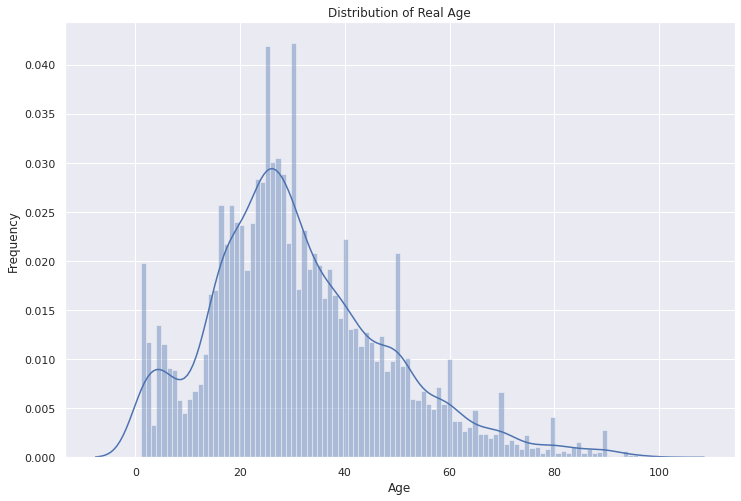

In [5]:
sns.distplot(labels["real_age"],  hist = True, bins=100);

plt.title("Distribution of Real Age")
plt.xlabel("Age")
plt.ylabel("Frequency")

plt.show()

На графике заметны пики значений чистот в области "десятков". Возможно это связано с резметкой датасета, при отсутствие реальных данных возраст мог подбираться "на глаз" методом округления.

Отобразим 30 случайных фото вместе с их реальным возрастом

In [6]:
x, y = next(train_gen_flow)

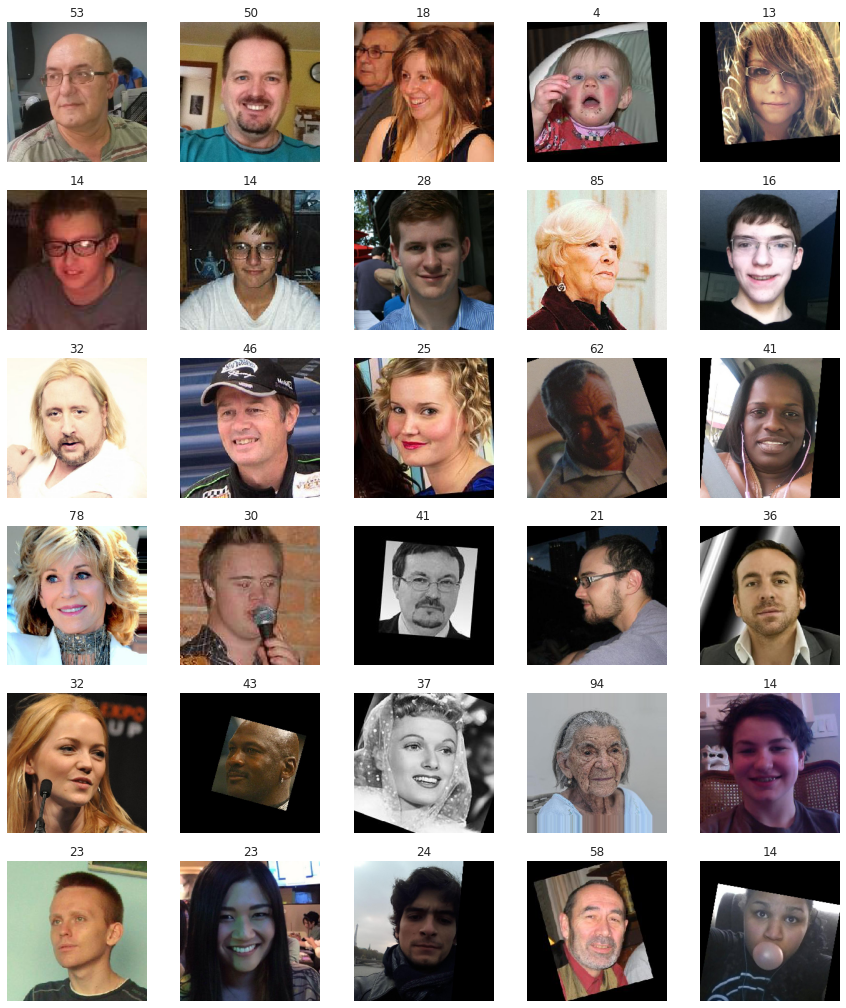

In [7]:
fig, axes = plt.subplots(6, 5, figsize=(15, 18))
axes = axes.flatten()

random.seed(42)  # seed для воспроизводимости случайной выборки
random_indices = random.sample(range(len(x)), 30)

for i, idx in enumerate(random_indices):
    age = y[idx]
    photo = x[idx]
    axes[i].imshow(photo)
    axes[i].set_title(age)
    axes[i].axis('off')


- Случайные фото выглядят подходящими для обучения. Лица на большенстве снимков находятся в центре.
- Имеются не квадратные изображения, развернутые ( ImageDataGenerator во время обучения сделает их квадратными) 
- Фотографий которые будут мешать обучению ( на фото человек находится далеко или трудно разлечим, на фото много людей) в случайно выборке не замечены. Будем считать что таких фото слишком мало чтобы помешать модели хорошо обучиться

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Весь набор данных был разделен на тренировочный и тестовый в соотношении 3:1. Для сети была выбрана предварительно обученная модель ResNet50 с 50 слоями и весами resnet50_weights_tf_dim_ordering_tf_kernels_notop, исключающая полносвязный слой по умолчанию.

Последний полносвязный слой был заменен на слой с одним нейроном, использующим функцию активации "relu", так как решается задача регрессии. 

**Дополнительно были установлены следующие параметры:**

- Оптимизационный алгоритм: Adam со скоростью обучения 0.0005,
- Функция потерь: Mean squared error,
- Метрика: Mean absolute error,
- Количество эпох обучения: 20.

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import pandas as pd 


def load_train(path):
    """ Loading of train dataset from 'final_files/' subfolder in `path`
    """
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.1,
    )

    return datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123,
    )


def load_test(path):
    """ Loading of test dataset from 'final_files/' subfolder in `path`
    """
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123,
    )


def create_model(input_shape):
    """ Creating of ResNet50 model for objects with shape = `input_shape`.  
        Custom fully-connected layer at the top of the network with `relu` activation for predict age value
    """
    backbone = ResNet50(
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        input_shape=input_shape, 
        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0005), 
                  loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """ Training of `model`
    
    ----
    `train_data` : DataFrameIterator for training dataset
    `test_data` : DataFrameIterator for validation dataset
    `epochs`, `batch_size` : params of keras.Model.fit()
    """
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs, batch_size=batch_size,
        steps_per_epoch=steps_per_epoch, #train_data.samples/train_data.batch_size,
        validation_steps=validation_steps, #test_data.samples/test_data.batch_size,
        verbose=2, shuffle=True)
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/20
2023-05-22 09:11:03.212009: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-22 09:11:03.771911: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 98s - loss: 200.8831 - mean_absolute_error: 10.6143 - val_loss: 292.4001 - val_mean_absolute_error: 12.8054
Epoch 2/20
178/178 - 93s - loss: 123.1658 - mean_absolute_error: 8.4186 - val_loss: 288.1935 - val_mean_absolute_error: 12.8052
Epoch 3/20
178/178 - 93s - loss: 110.2606 - mean_absolute_error: 7.9624 - val_loss: 273.4302 - val_mean_absolute_error: 12.8077
Epoch 4/20
178/178 - 93s - loss: 96.9972 - mean_absolute_error: 7.4630 - val_loss: 171.3495 - val_mean_absolute_error: 10.1237
Epoch 5/20
178/178 - 91s - loss: 89.5077 - mean_absolute_error: 7.1513 - val_loss: 200.9271 - val_mean_absolute_error: 10.8798
Epoch 6/20
178/178 - 94s - loss: 84.8470 - mean_absolute_error: 6.9836 - val_loss: 115.4546 - val_mean_absolute_error: 8.1129
Epoch 7/20
178/178 - 92s - loss: 78.1046 - mean_absolute_error: 6.7086 - val_loss: 132.4088 - val_mean_absolute_error: 8.4373
Epoch 8/20
178/178 - 93s - loss: 73.2545 - mean_absolute_error: 6.5333 - val_loss: 182.1867 - val_mean_absolute_error: 10.9243
Epoch 9/20
178/178 - 92s - loss: 71.0014 - mean_absolute_error: 6.3899 - val_loss: 87.8574 - val_mean_absolute_error: 6.9957
Epoch 10/20
178/178 - 93s - loss: 64.1135 - mean_absolute_error: 6.0584 - val_loss: 103.1708 - val_mean_absolute_error: 7.5981
Epoch 11/20
178/178 - 92s - loss: 61.8859 - mean_absolute_error: 5.9497 - val_loss: 90.7857 - val_mean_absolute_error: 7.4783
Epoch 12/20
178/178 - 93s - loss: 58.7706 - mean_absolute_error: 5.8477 - val_loss: 97.2052 - val_mean_absolute_error: 7.2567
Epoch 13/20
178/178 - 92s - loss: 51.1213 - mean_absolute_error: 5.4781 - val_loss: 100.0401 - val_mean_absolute_error: 7.4965
Epoch 14/20
178/178 - 90s - loss: 52.2389 - mean_absolute_error: 5.5363 - val_loss: 88.7903 - val_mean_absolute_error: 7.1062
Epoch 15/20
178/178 - 89s - loss: 45.8302 - mean_absolute_error: 5.2283 - val_loss: 90.8778 - val_mean_absolute_error: 6.9855
Epoch 16/20
178/178 - 90s - loss: 48.5212 - mean_absolute_error: 5.2623 - val_loss: 283.9189 - val_mean_absolute_error: 12.2444
Epoch 17/20
178/178 - 90s - loss: 52.8534 - mean_absolute_error: 5.4907 - val_loss: 87.9276 - val_mean_absolute_error: 6.8243
Epoch 18/20
178/178 - 91s - loss: 51.3728 - mean_absolute_error: 5.4523 - val_loss: 75.2799 - val_mean_absolute_error: 6.2102
Epoch 19/20
178/178 - 89s - loss: 41.9715 - mean_absolute_error: 4.9636 - val_loss: 81.3381 - val_mean_absolute_error: 6.5819
Epoch 20/20
178/178 - 92s - loss: 37.3995 - mean_absolute_error: 4.7272 - val_loss: 85.8137 - val_mean_absolute_error: 6.7792
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 85.8137 - mean_absolute_error: 6.7792
Test MAE: 6.7792

```

Итоговое качество модели на тесте: **mean_absolute_error 6.779**

## Анализ обученной модели

- Модель достигла значения средней абсолютной ошибки (MAE) равного 6.779 после 20 эпох обучения.

- Среднее отклонение модели при предсказании возраста на тестовой выборке составляет чуть менее 7 лет.

**Чтобы улучшить качество предсказаний модели, можно рассмотреть следующие подходы:**

- Увеличить количество эпох обучения для модели, чтобы дать ей больше возможностей для обучения и настройки весов.

- Исправить ошибки в детекции лиц в изображениях датасета. Некорректное определение и обрезка лиц может негативно повлиять на точность предсказаний модели. Улучшение процесса детекции лиц может привести к более точным результатам.


Таким образом, требуемое значение метрики MAE менее 8 мы достигли, но существуют возможности для дальнейшего улучшения качества предсказаний модели.